In [1]:
import sys
import math

sys.path.append('../../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn import datasets

from dal_toolbox.models.utils.random_features import RandomFeatureGaussianProcess
from dal_toolbox.models.resnet_sngp import train_one_epoch
from dal_toolbox.models.utils.spectral_normalization import spectral_norm_linear

/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


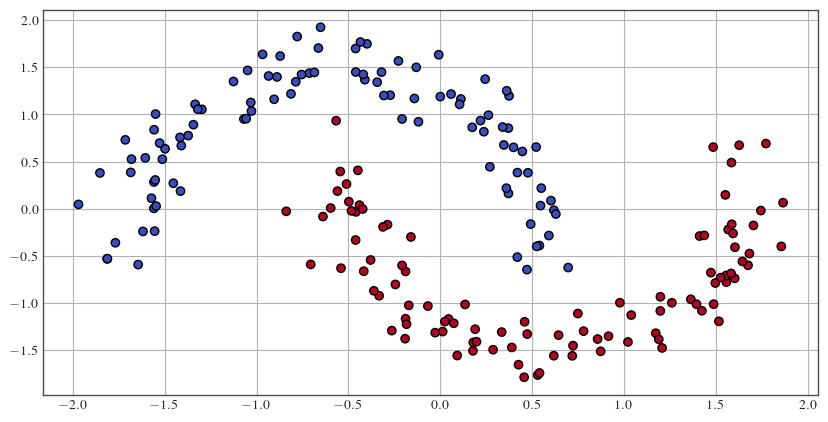

In [2]:
X, y = datasets.make_moons(200, noise=.1, random_state=42)
# X, y = datasets.make_circles(500, noise=.02)
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [3]:
class SNGPNet(nn.Module):
    def __init__(self,
                 num_classes: int,
                 use_spectral_norm: bool = True,
                 spectral_norm_params: dict = {},
                 gp_params: dict = {},
                 n_residual_layers: int = 6,
                 feature_dim: int = 128,
                 ):
        super().__init__()

        def linear_layer(*args, **kwargs):
            if use_spectral_norm:
                return spectral_norm_linear(nn.Linear(*args, **kwargs), **spectral_norm_params)
            else:
                return nn.Linear(*args, **kwargs)

        self.first = nn.Linear(2, feature_dim)
        self.residuals = nn.ModuleList([linear_layer(128, 128) for _ in range(n_residual_layers)])
        self.last = RandomFeatureGaussianProcess(
            in_features=feature_dim,
            out_features=num_classes,
            **gp_params,
        )
        self.act = nn.ReLU()

    def reset_precision_matrix(self):
        self.last.reset_precision_matrix()

    def forward(self, x, mean_field=False, return_cov=False):
        # : Added activation to first layer
        x = self.act(self.first(x))
        for residual in self.residuals:
            x = self.act(residual(x) + x)

        if mean_field:
            out = self.last.forward_mean_field(x)
        else:
            out = self.last(x, return_cov=return_cov)

        return out

    def log_marg_likelihood(self, inputs, targets, prior_precision=2000):
        # N, D = len(inputs)
        precision_matrix = self.last.precision_matrix
        prior_precision_matrix = prior_precision*torch.eye(len(self.last.precision_matrix))
        weight_map = self.last.beta.weight.data

        logits = self(inputs)
        log_likelihood = -F.cross_entropy(logits, targets, reduction='sum')
        complexity_term = 0.5 * ( 
                torch.logdet(precision_matrix) - torch.logdet(prior_precision_matrix) +
                weight_map@prior_precision_matrix@weight_map.T
        )
        lml = log_likelihood - complexity_term
        return lml.sum()


In [4]:
@torch.no_grad()
def plot_contour(model, X, y, ax=None):
    model.cpu()
    if ax:
        plt.sca(ax)
    domain = 5
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz, mean_field=True)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    # plt.title(f"Ep {}")
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.contourf(xx, yy, zz, alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

Epoch [0] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.6918 (0.6918) acc1: 57.8125 (57.8125) time: 0.4860 data: 0.0009 max mem: 15
Epoch [0] Total time: 0:00:00
Epoch [1] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.6874 (0.6874) acc1: 69.5312 (69.5312) time: 0.0072 data: 0.0011 max mem: 16
Epoch [1] Total time: 0:00:00
Epoch [2] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.6773 (0.6773) acc1: 84.3750 (84.3750) time: 0.0058 data: 0.0008 max mem: 16
Epoch [2] Total time: 0:00:00
Epoch [3] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.6664 (0.6664) acc1: 89.8438 (89.8438) time: 0.0082 data: 0.0007 max mem: 16
Epoch [3] Total time: 0:00:00
Epoch [4] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.6554 (0.6554) acc1: 96.8750 (96.8750) time: 0.0084 data: 0.0007 max mem: 16
Epoch [4] Total time: 0:00:00
Epoch [5] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.6463 (0.6463) acc1: 95.3125 (95.3125) time: 0.0086 data: 0.0010 max mem: 16
Epoch [5] Total time: 0:00:00
Epoch [6] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.6390 (0.6390) acc1: 96.8750 (96.8750) time

/home/denis/miniconda3/envs/uncertainty_evaluation/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484809662/work/aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


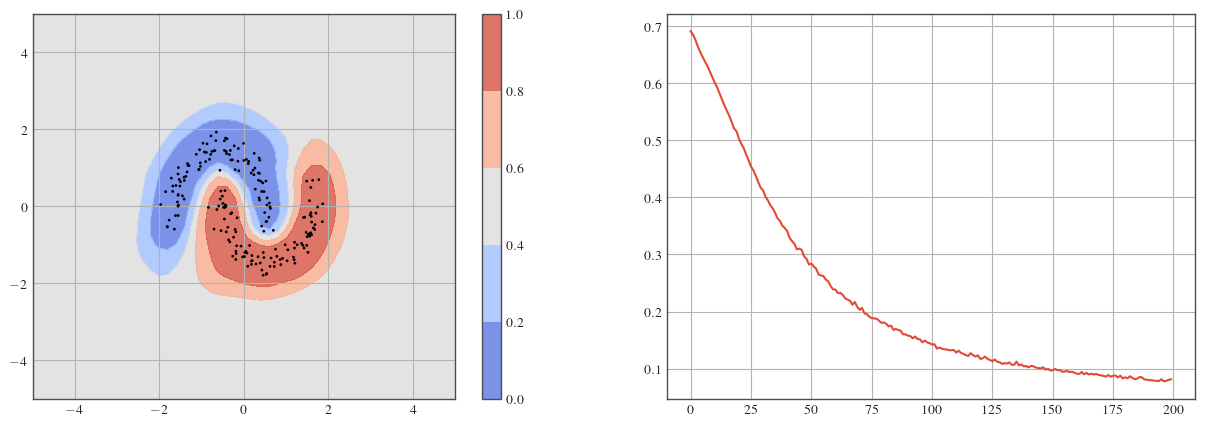

In [5]:
spectral_norm_params = dict(
    norm_bound=.9,
    n_power_iterations=1
)
gp_params = dict(
    num_inducing=1024,
    kernel_scale=0.05,
    random_feature_type='orf',
    scale_random_features=True,
    # normalize_input=False,
    # mean_field_factor=.1,
    # cov_momentum=-1,
    # ridge_penalty=1
)
optimizer_params = dict(
    lr=1e-2,
    weight_decay=1e-2,
    momentum=.9,
)
epochs = 200

torch.manual_seed(0)
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

model = SNGPNet(num_classes=2, use_spectral_norm=True, spectral_norm_params=spectral_norm_params, gp_params=gp_params)

optimizer = torch.optim.SGD(model.parameters(), **optimizer_params)
criterion = nn.CrossEntropyLoss()
history = []
for i in range(epochs):
    train_stats = train_one_epoch(model, train_loader, criterion, optimizer, device='cuda', epoch=i)
    history.append(train_stats)

model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot([d['train_loss'] for d in history])
plot_contour(model, X, y, ax=plt.subplot(121))
plt.show()

original_state_dict = model.state_dict()

# DEV

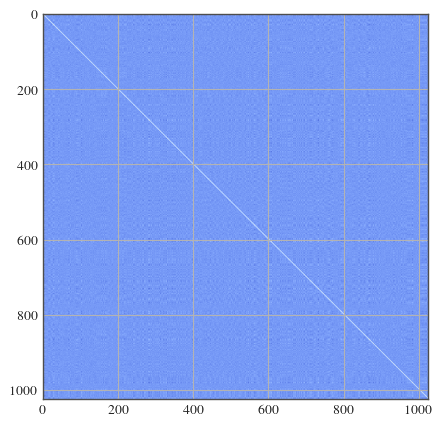

In [6]:
plt.imshow(model.last.precision_matrix)
plt.show()

In [7]:
model.load_state_dict(original_state_dict)

start_scale = model.last.random_features.input_scale

lmls = []
optimizer = torch.optim.SGD(model.last.beta.parameters(), **optimizer_params)
kernel_scales = torch.linspace(0.1, 5, 41)
for kernel_scale in kernel_scales: 
    model.last.random_features.input_scale = kernel_scale
    criterion = nn.CrossEntropyLoss()
    history = []
    for i in range(epochs):
        train_stats = train_one_epoch(model, train_loader, criterion, optimizer, device='cuda', epoch=i)
        history.append(train_stats)
    model.eval()
    model.cpu()
    lmls.append(model.log_marg_likelihood(X, y).detach())
    print(lmls[-1])

plt.plot(kernel_scales, lmls)
plt.vlines(start_scale, *plt.ylim(), 'k')
plt.show()

model.last.random_features.input_scale = kernel_scales[np.argmax(lmls)]
criterion = nn.CrossEntropyLoss()
history = []
for i in range(epochs):
    train_stats = train_one_epoch(model, train_loader, criterion, optimizer, device='cuda', epoch=i)
    history.append(train_stats)
model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot([d['train_loss'] for d in history])
plot_contour(model, X, y, ax=plt.subplot(121))
plt.show()

Epoch [0] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.6959 (0.6959) acc1: 50.7812 (50.7812) time: 0.0090 data: 0.0011 max mem: 16
Epoch [0] Total time: 0:00:00
Epoch [1] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.6952 (0.6952) acc1: 51.5625 (51.5625) time: 0.0103 data: 0.0009 max mem: 16
Epoch [1] Total time: 0:00:00
Epoch [2] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.6958 (0.6958) acc1: 50.7812 (50.7812) time: 0.0109 data: 0.0009 max mem: 16
Epoch [2] Total time: 0:00:00
Epoch [3] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.6969 (0.6969) acc1: 49.2188 (49.2188) time: 0.0105 data: 0.0009 max mem: 16
Epoch [3] Total time: 0:00:00
Epoch [4] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.7006 (0.7006) acc1: 44.5312 (44.5312) time: 0.0105 data: 0.0009 max mem: 16
Epoch [4] Total time: 0:00:00
Epoch [5] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.6964 (0.6964) acc1: 49.2188 (49.2188) time: 0.0100 data: 0.0008 max mem: 16
Epoch [5] Total time: 0:00:00
Epoch [6] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.6933 (0.6933) acc1: 53.1250 (53.1250) time

KeyboardInterrupt: 

4.47213595499958 tensor([0.9900], requires_grad=True)


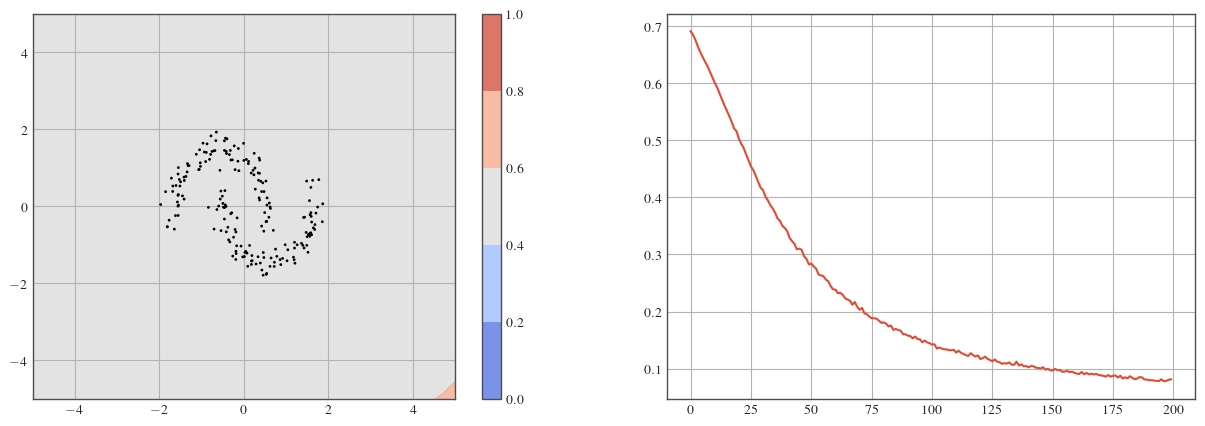

In [ ]:
model.load_state_dict(original_state_dict)
start_scale = model.last.random_features.input_scale

input_scale = torch.ones(1, requires_grad=True)
hparam_optimizer = torch.optim.Adam([input_scale])
for i in range(10):
    model.last.random_features.input_scale = input_scale

    lml = -model.log_marg_likelihood(X, y)

    hparam_optimizer.zero_grad()
    lml.backward()
    hparam_optimizer.step()

print(start_scale, input_scale)

plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot([d['train_loss'] for d in history])
plot_contour(model, X, y, ax=plt.subplot(121))
plt.show()

In [21]:
scale = np.argmax(lmls)
scale

4

Epoch [0] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.0068 (0.0068) acc1: 100.0000 (100.0000) time: 0.0061 data: 0.0008 max mem: 21
Epoch [0] Total time: 0:00:00
Epoch [1] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.0070 (0.0070) acc1: 100.0000 (100.0000) time: 0.0053 data: 0.0008 max mem: 21
Epoch [1] Total time: 0:00:00
Epoch [2] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.0047 (0.0047) acc1: 100.0000 (100.0000) time: 0.0052 data: 0.0007 max mem: 21
Epoch [2] Total time: 0:00:00
Epoch [3] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.0041 (0.0041) acc1: 100.0000 (100.0000) time: 0.0054 data: 0.0008 max mem: 21
Epoch [3] Total time: 0:00:00
Epoch [4] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.0070 (0.0070) acc1: 100.0000 (100.0000) time: 0.0055 data: 0.0008 max mem: 21
Epoch [4] Total time: 0:00:00
Epoch [5] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.0044 (0.0044) acc1: 100.0000 (100.0000) time: 0.0053 data: 0.0008 max mem: 21
Epoch [5] Total time: 0:00:00
Epoch [6] [0/2] eta: 0:00:00 lr: 0.01 loss: 0.0075 (0.0075) acc1: 100.0000 (

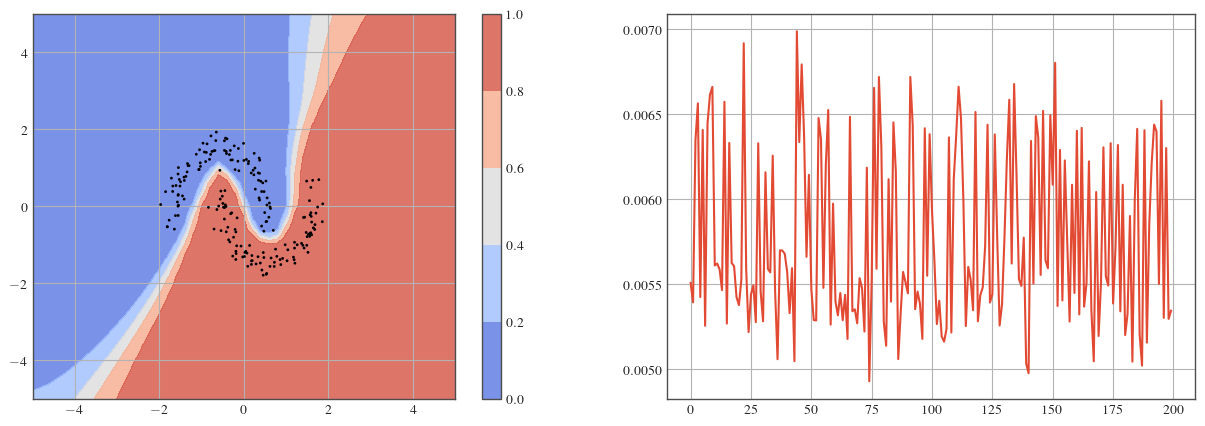

In [ ]:
model.last.random_features.input_scale = kernel_scales[np.argmax(lmls)]
criterion = nn.CrossEntropyLoss()
history = []
for i in range(epochs):
    train_stats = train_one_epoch(model, train_loader, criterion, optimizer, device='cuda', epoch=i)
    history.append(train_stats)
model.eval()
plt.figure(figsize=(15, 5))
plt.subplot(122)
plt.plot([d['train_loss'] for d in history])
plot_contour(model, X, y, ax=plt.subplot(121))
plt.show()